In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import argparse
import os

import numpy as np
import torch
from torch.nn.modules.loss import CrossEntropyLoss
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
import random

from handwriting_recognition.label_converter import LabelConverter
from handwriting_recognition.model.model import HandwritingRecognitionModel
from handwriting_recognition.modelling_utils import get_image_model
from handwriting_recognition.utils import TrainingConfig, get_dataset_folder_path
from handwriting_recognition.dataset import HandWritingDataset
from pathlib import Path
from handwriting_recognition.modelling_utils import get_device
from handwriting_recognition.eval import cer, wer

torch.backends.cudnn.benchmark = True

In [ ]:
CONFIG_NAME = "resnet_config"
MODEL_DIR = Path(get_dataset_folder_path()).parent.joinpath("model_outputs", CONFIG_NAME)
config_path = Path(get_dataset_folder_path()).parent.joinpath("handwriting_recognition", "configs", CONFIG_NAME).with_suffix(".json")
config = TrainingConfig.from_path(config_path=config_path)

In [ ]:
all_epochs = [x for x in sorted(os.listdir(MODEL_DIR)) if x.isdigit()]

In [ ]:
all_epochs

In [ ]:
BATCH_SIZE = 192

In [15]:
from handwriting_recognition.train import _evaluate

data_train = HandWritingDataset(
data_path=get_dataset_folder_path() / "pre_processed" / "train.csv",
img_size=config.feature_extractor_config.input_size,
)

data_val = HandWritingDataset(
    data_path=get_dataset_folder_path() / "pre_processed" / "validation.csv",
    img_size=config.feature_extractor_config.input_size,
)

train_loader = DataLoader(
    data_train,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=False,
    drop_last=False,
)

val_loader = DataLoader(
    data_val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=False,
    drop_last=False,
)
loss_function = CrossEntropyLoss(ignore_index=0).to(get_device())

val_metrics = []
train_metrics = []

for epoch in all_epochs:
    model_file = os.path.join(MODEL_DIR, epoch)
    saved_model = torch.load(model_file)
    config = TrainingConfig(**saved_model['config'])

    image_model = get_image_model(model_name=config.feature_extractor_config.model_name)
    model = HandwritingRecognitionModel(image_feature_extractor=image_model, training_config=config)
    model.load_state_dict(saved_model["state"])
    converter = LabelConverter(character_set=saved_model['character_set'], max_text_length=saved_model['max_text_length'])
    
    model = model.to(get_device())
    model = model.eval()

    validation_loss, val_character_error_rate, val_word_error_rate, all_val_preds, all_val_ground_truths = _evaluate(
        epoch=saved_model['epoch'],
        model=model,
        data_loader=val_loader,
        converter=converter,
        loss_function=loss_function,
        max_iter=250,
    )
    val_metrics.append({
        "loss": validation_loss.item(),
        "epoch": int(epoch),
        "cer": val_character_error_rate.item(),
        "wer": val_word_error_rate.item(),
        "preds": all_val_preds,
        "ground_truths": all_val_ground_truths
    })
    train_loss, train_character_error_rate, train_word_error_rate, all_train_preds, all_train_ground_truths = _evaluate(
        epoch=saved_model['epoch'],
        model=model,
        data_loader=train_loader,
        converter=converter,
        loss_function=loss_function,
        max_iter=250
    )
    train_metrics.append({
        "loss": train_loss.item(),
        "epoch": int(epoch),
        "cer": train_character_error_rate.item(),
        "wer": train_word_error_rate.item(),
        "preds": all_train_preds,
        "ground_truths": all_train_ground_truths
    })
    print(
        f"Validation Loss at epoch {epoch}: {validation_loss:.4f}, WER: {val_word_error_rate}, CER: {val_character_error_rate}. Best Loss so far:"
    )
    
    print(
        f"Training Loss at epoch {epoch}: {train_loss:.4f}, WER: {train_word_error_rate}, CER: {train_character_error_rate}. Best Loss so far:"
    )

Validating Epoch: 1: 100% 208/208 [00:40<00:00,  5.16it/s]


Outputting sample of validation outputs.
['ALICE', 'BENTELLER', 'CARILLIER', 'LISA', 'BOURET', 'MATHIS', 'MATHIS', 'BENTE   BARIER', 'MATHIS', 'LUCA']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 1:  15% 249/1661 [00:48<04:34,  5.14it/s]


Outputting sample of validation outputs.
['BENTELLER', 'LOUIS', 'LOUIS', 'BERRET', 'MATHIS', 'ALICE', 'MATHIS', 'BERRAUDE', 'ANTOINE', 'ALICE']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 1: 3.1855, WER: 1.0079501867294312, CER: 0.8393059968948364. Best Loss so far:
Training Loss at epoch 1: 3.1864, WER: 1.0059702396392822, CER: 0.8385910987854004. Best Loss so far:


Validating Epoch: 10: 100% 208/208 [00:40<00:00,  5.18it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMOHIER', 'JEAN ROCH', 'RUPA', 'PICHON', 'DANZEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 10:  15% 249/1661 [00:48<04:32,  5.18it/s]


Outputting sample of validation outputs.
['BALTHAIRR', 'SIMON', 'BENES', 'LALOUE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'JLAVIAN', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 10: 0.3873, WER: 0.32397031784057617, CER: 0.08868416398763657. Best Loss so far:
Training Loss at epoch 10: 0.3710, WER: 0.3147127330303192, CER: 0.085292287170887. Best Loss so far:


Validating Epoch: 11: 100% 208/208 [00:39<00:00,  5.21it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEHN MIENEL', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 11:  15% 249/1661 [00:47<04:32,  5.19it/s]


Outputting sample of validation outputs.
['BALTHAIAR', 'SIMON', 'BENES', 'LALOUE', 'DAPANE', 'LUCIE', 'MASSIM', 'ASSRAQUI', 'TIAVIAN', 'MAEYA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 11: 0.4365, WER: 0.36671456694602966, CER: 0.10340099036693573. Best Loss so far:
Training Loss at epoch 11: 0.4169, WER: 0.3592509329319, CER: 0.09983063489198685. Best Loss so far:


Validating Epoch: 12: 100% 208/208 [00:39<00:00,  5.21it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCH', 'RUFP', 'PICHON', 'BANIEL', 'JEREMY', 'TEHNEICHE', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 12:  15% 249/1661 [00:48<04:33,  5.16it/s]


Outputting sample of validation outputs.
['BAITHAIAR', 'GIMON', 'BENES', 'LALOUE', 'DAPHAE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'YLAVIAN', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 12: 0.4857, WER: 0.39738985896110535, CER: 0.11707331985235214. Best Loss so far:
Training Loss at epoch 12: 0.4711, WER: 0.39493322372436523, CER: 0.11339537799358368. Best Loss so far:


Validating Epoch: 13: 100% 208/208 [00:39<00:00,  5.22it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMOHIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MIENEL', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 13:  15% 249/1661 [00:48<04:34,  5.15it/s]


Outputting sample of validation outputs.
['BALTHAIRA', 'SIMON', 'BENES', 'LALOUE', 'DAPHNE', 'LUCIE', 'MASSIM', 'ASSRAOUI', 'YLAVIAN', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 13: 0.3587, WER: 0.3042624592781067, CER: 0.08091434091329575. Best Loss so far:
Training Loss at epoch 13: 0.3441, WER: 0.29419490694999695, CER: 0.07664252817630768. Best Loss so far:


Validating Epoch: 14: 100% 208/208 [00:40<00:00,  5.19it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCH', 'RUPA', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MIENEL', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 14:  15% 249/1661 [00:47<04:32,  5.19it/s]


Outputting sample of validation outputs.
['BALTHAIAR', 'GIMON', 'BENES', 'LALOUE', 'DAPHUE', 'LUCIE', 'MASSIN', 'ASSRAOUI', 'JUAVIAN', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 14: 0.4366, WER: 0.35445401072502136, CER: 0.09981665015220642. Best Loss so far:
Training Loss at epoch 14: 0.4136, WER: 0.34436506032943726, CER: 0.09444919228553772. Best Loss so far:


Validating Epoch: 15: 100% 208/208 [00:39<00:00,  5.26it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MIENEL', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 15:  15% 249/1661 [00:48<04:33,  5.17it/s]


Outputting sample of validation outputs.
['BALTHAIAR', 'GIMON', 'BENES', 'LALOUE', 'DAPHNE', 'LUCIE', 'MASSIM', 'ASSRAOUI', 'YLAVIAN', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 15: 0.4344, WER: 0.3695402443408966, CER: 0.10092876851558685. Best Loss so far:
Training Loss at epoch 15: 0.4150, WER: 0.357619047164917, CER: 0.09651536494493484. Best Loss so far:


Validating Epoch: 16: 100% 208/208 [00:40<00:00,  5.19it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEHN MICHEL', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 16:  15% 249/1661 [00:48<04:34,  5.15it/s]


Outputting sample of validation outputs.
['BALTHAIAR', 'SIMON', 'BENES', 'LALOUE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'YLAVIAN', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 16: 0.3601, WER: 0.2998563349246979, CER: 0.08049730211496353. Best Loss so far:
Training Loss at epoch 16: 0.3471, WER: 0.29061275720596313, CER: 0.07705263793468475. Best Loss so far:


Validating Epoch: 17: 100% 208/208 [00:40<00:00,  5.18it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCH', 'RUPA', 'PICHON', 'BANIEL', 'JEREMY', 'JEPNIMICHEL', 'JULIEN', 'NAGL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 17:  15% 249/1661 [00:48<04:34,  5.14it/s]


Outputting sample of validation outputs.
['BALTHAIAR', 'SIMON', 'BENES', 'LALOUE', 'DAPHNE', 'GUCIE', 'MASSIM', 'ASSRAOUI', 'YLAVIAN', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 17: 0.4780, WER: 0.38697317242622375, CER: 0.10960783064365387. Best Loss so far:
Training Loss at epoch 17: 0.4602, WER: 0.3779378831386566, CER: 0.10604167729616165. Best Loss so far:


Validating Epoch: 18: 100% 208/208 [00:40<00:00,  5.16it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'TEHN MIENELE', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 18:  15% 249/1661 [00:48<04:34,  5.15it/s]


Outputting sample of validation outputs.
['BALTHAITRA', 'SIMON', 'BENES', 'LALOUE', 'DAPHNE', 'JUCIE', 'NASSIN', 'ASSRAOUI', 'YLAVIAN', 'MAEYA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 18: 0.4080, WER: 0.3425047993659973, CER: 0.09560862183570862. Best Loss so far:
Training Loss at epoch 18: 0.3948, WER: 0.336762934923172, CER: 0.09189777821302414. Best Loss so far:


Validating Epoch: 19: 100% 208/208 [00:40<00:00,  5.16it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEHN MICHEL', 'JULIEN', 'MAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 19:  15% 249/1661 [00:48<04:35,  5.13it/s]


Outputting sample of validation outputs.
['BALTHAIAR', 'SIMON', 'BENES', 'LALOUE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'YLAVIAN', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 19: 0.3408, WER: 0.28936782479286194, CER: 0.07641325891017914. Best Loss so far:
Training Loss at epoch 19: 0.3245, WER: 0.2793090343475342, CER: 0.07187780737876892. Best Loss so far:


Validating Epoch: 2: 100% 208/208 [00:40<00:00,  5.19it/s]


Outputting sample of validation outputs.
['BOLLE', 'LAURANDES', 'FERRANDER', 'RAUX', 'PICHOT', 'JADILE', 'JEANNE', 'FERNANDERE', 'JULIEN', 'MAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 2:  15% 249/1661 [00:48<04:34,  5.15it/s]


Outputting sample of validation outputs.
['BASTARDAN', 'SORIA', 'DENIS', 'CASSIE', 'THOMAS', 'CULIE', 'MAELYS', 'MOURAULT', 'TIMOTHA', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 2: 2.0120, WER: 0.8631705045700073, CER: 0.5623539686203003. Best Loss so far:
Training Loss at epoch 2: 2.0019, WER: 0.8599374890327454, CER: 0.5604528188705444. Best Loss so far:


Validating Epoch: 20: 100% 208/208 [00:40<00:00,  5.16it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 20:  15% 249/1661 [00:48<04:35,  5.12it/s]


Outputting sample of validation outputs.
['BALTHAIRR', 'SIMON', 'BENES', 'LALOUE', 'DAPHNE', 'LUCIE', 'MASSIN', 'ASSRAUI', 'YLAVIAN', 'MACYA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 20: 0.4707, WER: 0.36266762018203735, CER: 0.10204840451478958. Best Loss so far:
Training Loss at epoch 20: 0.4543, WER: 0.3554697632789612, CER: 0.09895721077919006. Best Loss so far:


Validating Epoch: 3: 100% 208/208 [00:40<00:00,  5.15it/s]


Outputting sample of validation outputs.
['BILLE', 'LAUMENTER', 'JEAN ABER', 'RUBA', 'PICHON', 'BANIEL', 'LERENN', 'JEAN MATHEAU', 'JULIEN', 'MAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 3:  15% 249/1661 [00:48<04:34,  5.15it/s]


Outputting sample of validation outputs.
['BALANNEAU', 'GINON', 'DENES', 'CALOSE', 'DAPHIE', 'LOCIE', 'MAEVON', 'ROGANDOT', 'DENTIAN', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 3: 1.2639, WER: 0.7294779419898987, CER: 0.3651515245437622. Best Loss so far:
Training Loss at epoch 3: 1.2538, WER: 0.7241536974906921, CER: 0.36166495084762573. Best Loss so far:


Validating Epoch: 4: 100% 208/208 [00:40<00:00,  5.16it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCH', 'RUPA', 'PICHON', 'DAMIEL', 'JEREMY', 'JEAN MALUEL', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 4:  15% 249/1661 [00:48<04:34,  5.15it/s]


Outputting sample of validation outputs.
['BALTHAIRA', 'SIMON', 'BENES', 'LALOUE', 'DAPHNE', 'LOCIE', 'MASSIM', 'ASSAROUI', 'FLAVIAN', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 4: 0.7097, WER: 0.5178160667419434, CER: 0.19890441000461578. Best Loss so far:
Training Loss at epoch 4: 0.6918, WER: 0.5079106092453003, CER: 0.19344709813594818. Best Loss so far:


Validating Epoch: 5: 100% 208/208 [00:40<00:00,  5.14it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCH', 'RUPA', 'PICHON', 'DANIEL', 'JEREMY', 'SEAN   LIENEL', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 5:  15% 249/1661 [00:48<04:35,  5.13it/s]


Outputting sample of validation outputs.
['BALTHASAR', 'GIMON', 'BENES', 'LACOUE', 'DAPHNE', 'LUCIE', 'MASSIM', 'ASSAROUI', 'PLAVIAN', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 5: 0.6375, WER: 0.4877873659133911, CER: 0.17620360851287842. Best Loss so far:
Training Loss at epoch 5: 0.6179, WER: 0.4786961078643799, CER: 0.17112615704536438. Best Loss so far:


Validating Epoch: 6: 100% 208/208 [00:39<00:00,  5.21it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCCH', 'RUPA', 'PICHON', 'DANIEL', 'JERIAN', 'TEAN MIENEL', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 6:  15% 249/1661 [00:48<04:34,  5.15it/s]


Outputting sample of validation outputs.
['BALTHAIRA', 'SIMON', 'BENOS', 'LALOUE', 'DAPHNE', 'LOCIE', 'MASSIM', 'ASSRAOUI', 'VIANIAN', 'MAENA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 6: 0.6807, WER: 0.5285201072692871, CER: 0.18052810430526733. Best Loss so far:
Training Loss at epoch 6: 0.6648, WER: 0.5256025195121765, CER: 0.17704293131828308. Best Loss so far:


Validating Epoch: 7: 100% 208/208 [00:40<00:00,  5.19it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCCH', 'RUPA', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN    MILLEEL', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 7:  15% 249/1661 [00:48<04:33,  5.17it/s]


Outputting sample of validation outputs.
['BALTHAIRR', 'SIMON', 'BENES', 'LALOUC', 'DAPHNE', 'JUCIE', 'MASSIN', 'ASSRAOUI', 'YLANIAN', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 7: 0.5250, WER: 0.3972701132297516, CER: 0.12506480515003204. Best Loss so far:
Training Loss at epoch 7: 0.5008, WER: 0.38448527455329895, CER: 0.12025758624076843. Best Loss so far:


Validating Epoch: 8: 100% 208/208 [00:39<00:00,  5.22it/s]


Outputting sample of validation outputs.
['BILEEL', 'LAUMONIER', 'JEAN ROCH', 'RUPA', 'PICHON', 'DANIEL', 'JEREMY', 'FERN MIENCE', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 8:  15% 249/1661 [00:48<04:33,  5.16it/s]


Outputting sample of validation outputs.
['BALTHAIRR', 'GIMON', 'BENES', 'LALOUE', 'DAPHNE', 'LUCIE', 'MASSIN', 'ASSRAOUI', 'YLAVIAN', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 8: 0.5067, WER: 0.41582855582237244, CER: 0.1244523897767067. Best Loss so far:
Training Loss at epoch 8: 0.4880, WER: 0.404326468706131, CER: 0.11994452774524689. Best Loss so far:


Validating Epoch: 9: 100% 208/208 [00:40<00:00,  5.19it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 9:  15% 249/1661 [00:47<04:31,  5.20it/s]


Outputting sample of validation outputs.
['BALTVAIRR', 'SIMON', 'BENES', 'LALOUE', 'DARANE', 'LUCIE', 'MASSIN', 'ASSRAOUI', 'VIANIAN', 'MAEWA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 9: 0.5225, WER: 0.4347701072692871, CER: 0.12908121943473816. Best Loss so far:
Training Loss at epoch 9: 0.5065, WER: 0.4274314045906067, CER: 0.12504422664642334. Best Loss so far:


In [46]:
import pickle

with open("train_metrics.pkl", 'wb') as f:
    pickle.dump(train_metrics, f)
    
with open("val_metrics.pkl", 'wb') as f:
    pickle.dump(val_metrics, f)

In [47]:
all_val_losses = [(x['loss'], x['epoch']) for x in val_metrics]
all_train_losses = [(x['loss'], x['epoch']) for x in train_metrics]

all_val_losses.sort(key=lambda x: x[1])
all_train_losses.sort(key=lambda x: x[1])

In [48]:
val_loss, val_epochs = zip(*all_val_losses)
train_loss, train_epochs = zip(*all_train_losses)

In [49]:
train_loss

(3.1864354610443115,
 2.001875400543213,
 1.2538414001464844,
 0.6917925477027893,
 0.6179085373878479,
 0.664823055267334,
 0.5007858276367188,
 0.4880155026912689,
 0.5064628720283508,
 0.3710483908653259,
 0.41694536805152893,
 0.47110146284103394,
 0.3440956175327301,
 0.4135979115962982,
 0.41495969891548157,
 0.34711483120918274,
 0.46023255586624146,
 0.39481881260871887,
 0.32451871037483215,
 0.4542522430419922)

In [50]:
all_val_cer = [(x['cer'], x['epoch']) for x in val_metrics]
all_train_cer = [(x['cer'], x['epoch']) for x in train_metrics]

all_val_cer.sort(key=lambda x: x[1])
all_train_cer.sort(key=lambda x: x[1])

In [51]:
val_cer, val_epochs = zip(*all_val_cer)
train_cer, train_epochs = zip(*all_train_cer)

In [52]:
import matplotlib.pyplot as plt

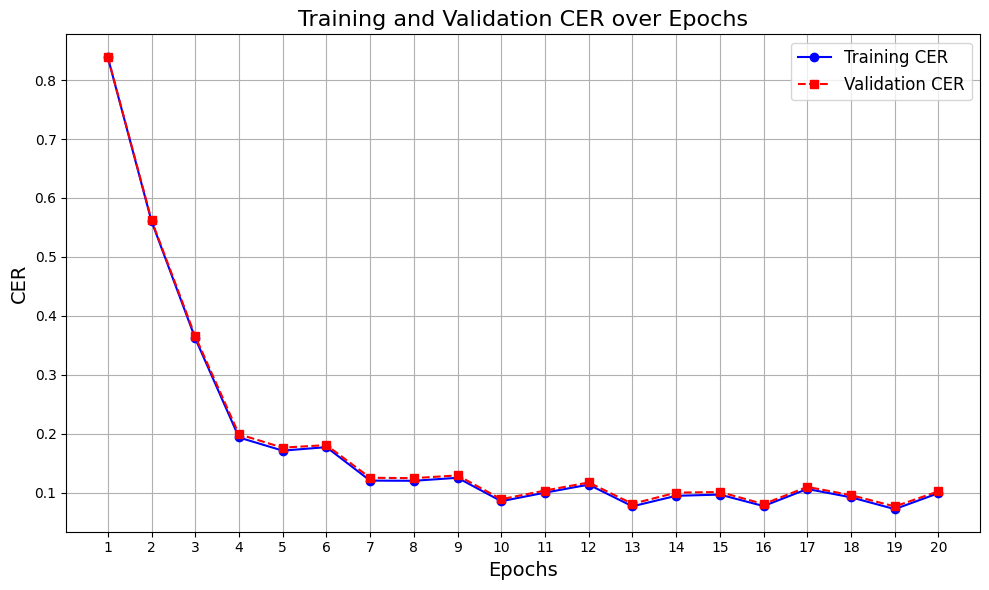

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(train_epochs, train_cer, marker='o', linestyle='-', color='b', label='Training CER')
plt.plot(val_epochs, val_cer, marker='s', linestyle='--', color='r', label='Validation CER')

plt.title('Training and Validation CER over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('CER', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(range(1, max(train_epochs) + 1)) 

plt.tight_layout()
plt.show()

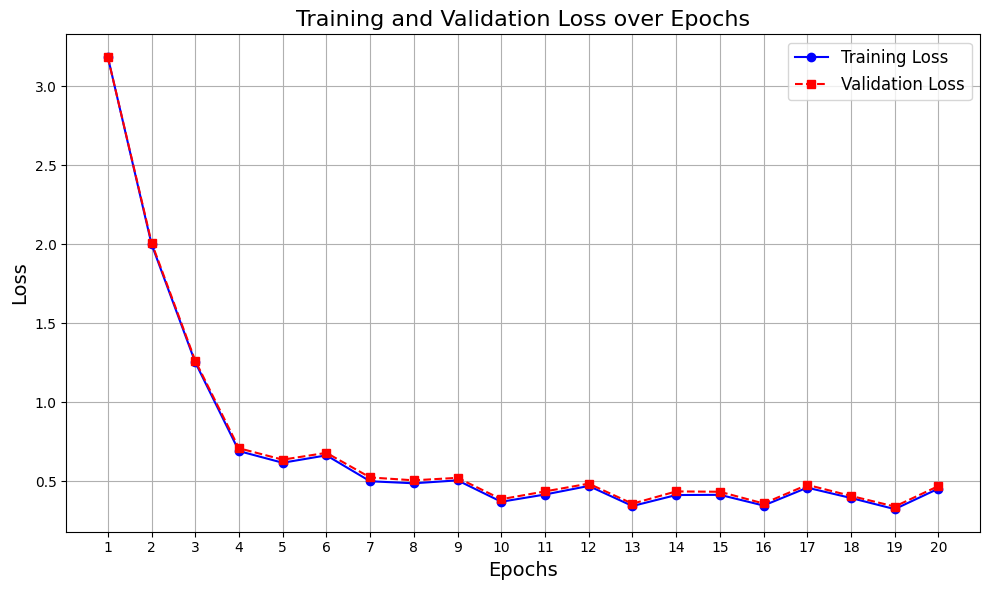

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(train_epochs, train_loss, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(val_epochs, val_loss, marker='s', linestyle='--', color='r', label='Validation Loss')

plt.title('Training and Validation Loss over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(range(1, max(train_epochs) + 1)) 

plt.tight_layout()
plt.show()